Objective: The goal of this assignment is to leverage PySpark for big data processing and analysis, applying
machine learning algorithms to predict the popularity of online news articles. You'll work with the Online
News Popularity dataset, focusing on understanding the features that contribute to the popularity of an
article and building a predictive model.

In [6]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1ac229784f12f139b87564833240d63aa78dbff960065ee6cdbf50aaec30594e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
!pip install ucimlrepo

1. Setup and Data Preparation
● Install and configure PySpark in your environment.
● Initialize a Spark session and load the Online News Popularity dataset into a PySpark DataFrame.
● Familiarize yourself with the dataset's structure and types of variables available.

In [4]:
from ucimlrepo import fetch_ucirepo

# Fetching the dataset
online_news_data = fetch_ucirepo(id=332)

# Extracting features and targets
features = online_news_data.data.features
targets = online_news_data.data.targets

# # Metadata display (commented out)
# print("\nDataset Metadata:")
# print(online_news_data.metadata)

# # Display variable information (commented out)
# print("\nVariable Information:")

from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark_session = SparkSession.builder.appName("OnlineNewsPopularity").getOrCreate()

# Merging features and targets into a single DataFrame
combined_df = pd.concat([features, targets], axis=1)

# Convert the merged DataFrame to a PySpark DataFrame without explicitly defining a schema
spark_df = spark_session.createDataFrame(combined_df)

# Display the first few rows of the PySpark DataFrame
spark_df.show(5)


+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

2. Data Preprocessing
● Perform data cleaning, including dealing with missing values and any irrelevant features.
● Since the dataset contains URL data as non-predictive, ensure this is excluded from your analysis.
● Convert the dataset's target variable (shares) into a binary outcome for classification (popular vs. not
popular) based on a threshold you define (e.g., median value).

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# # Task 1: Setup and Data Preparation
# # Initialize a Spark session
# spark = SparkSession.builder.appName("NewsPopularity").getOrCreate()

# # Load the Online News Popularity dataset into a PySpark DataFrame
# data = spark.read.csv("OnlineNewsPopularity.csv", header=True, inferSchema=True)

# Print the dataset schema to understand its structure
spark_df.printSchema()

# Task 2: Data Preprocessing
# Remove irrelevant features, including the URL column (already excluded in the schema)
# Convert the 'shares' column to a binary outcome (popular vs. not popular)
median_shares = spark_df.approxQuantile(" shares", [0.5], 0.0)[0]
data = spark_df.withColumn("label", when(col(" shares") >= median_shares, 1).otherwise(0))

# Select features for the model and assemble them into a feature vector
feature_columns = [col for col in data.columns if col not in ['shares', 'label']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Task 3: Model Training and Evaluation
# Create a RandomForestClassifier model
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label")

# Define a Pipeline that includes feature assembly and the classifier
pipeline = Pipeline(stages=[assembler, rf_classifier])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.2f}")

root
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: double (nullable = true)
 |--  kw_avg_min: double (nullable = true)
 |--  kw_mi

In [6]:
print("\n Statistics:")
spark_df.describe().show()
print("---------------------------------------------------------------------------------")
# Drop rows with any null values
df_cleaned = spark_df.na.drop()

# Show the first few rows of the cleaned DataFrame
df_cleaned.show(5)

# Display summary statistics for the cleaned features
print("\nSummary statistics for cleaned features:")
df_cleaned.describe().show()
print("---------------------------------------------------------------------------------")
from pyspark.sql.functions import when, col

median_shares = spark_df.approxQuantile(" shares", [0.5], 0.01)[0]
spark_df = df_cleaned.withColumn("shares_binary", when(col(" shares") >= median_shares, 1).otherwise(0))

# Show the first few rows of the preprocessed DataFrame
spark_df.show(5)


 Statistics:
+-------+------------------+-----------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+---------------------------+-------------------------

3. Exploratory Data Analysis (EDA)
● Conduct EDA to understand the characteristics of popular and non-popular articles.
● Analyze the distribution of key features and their impact on news popularity.
4. Feature Engineering
● Create new features that could potentially enhance model performance, such as article length
categories, weekday of publication, etc.
● Use VectorAssembler to combine all feature columns into a single vector column.

In [7]:
from pyspark.sql.functions import col, count, mean, stddev, corr

# Calculate summary statistics for articles with different levels of shares
df_summary = spark_df.groupby("shares_binary").agg(
    count("*").alias("total_articles"),
    mean(" n_tokens_title").alias("average_title_length"),
    mean(" n_tokens_content").alias("average_content_length"),
    mean(" num_hrefs").alias("average_num_hrefs"),
    mean(" num_imgs").alias("average_num_imgs"),
    mean(" num_videos").alias("average_num_videos"),
    mean(" shares").alias("average_shares"),
    mean(" global_subjectivity").alias("average_global_subjectivity"),
    mean(" global_sentiment_polarity").alias("average_global_sentiment_polarity"),
    mean(" rate_positive_words").alias("average_rate_positive_words"),
    mean(" rate_negative_words").alias("average_rate_negative_words")
)

df_summary.show()

# Analyze distribution of key features among articles with different levels of shares
key_features = [
    " n_tokens_title", " n_tokens_content", " num_hrefs", " num_imgs",
    " num_videos", " global_subjectivity", " global_sentiment_polarity",
    " rate_positive_words", " rate_negative_words"
]

for feature in key_features:
    spark_df.groupby("shares_binary").agg(
        mean(col(feature)).alias(f"avg_{feature}"),
        stddev(col(feature)).alias(f"stddev_{feature}")
    ).show()

# Perform correlation analysis between features and the target variable
for feature in key_features:
    correlation = spark_df.stat.corr(feature, "shares_binary")
    print(f"Correlation between {feature} and shares_binary: {correlation:.2f}")


+-------------+--------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+---------------------------+---------------------------------+---------------------------+---------------------------+
|shares_binary|total_articles|average_title_length|average_content_length| average_num_hrefs|  average_num_imgs|average_num_videos|   average_shares|average_global_subjectivity|average_global_sentiment_polarity|average_rate_positive_words|average_rate_negative_words|
+-------------+--------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+---------------------------+---------------------------------+---------------------------+---------------------------+
|            1|         21154|  10.311761369008225|     564.7633544483313|11.839604802874161| 5.066134064479531|1.2781034319750402|5568.213860262835|         0.4507946492337189|               0.12

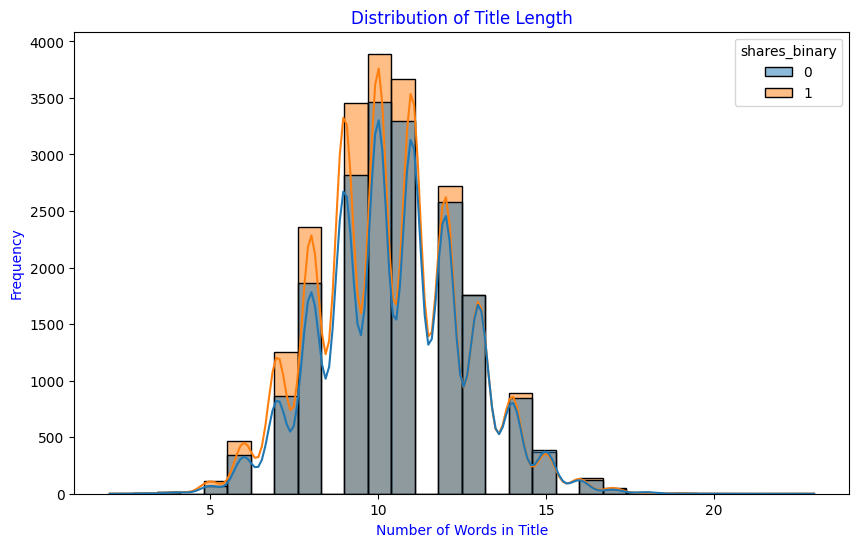

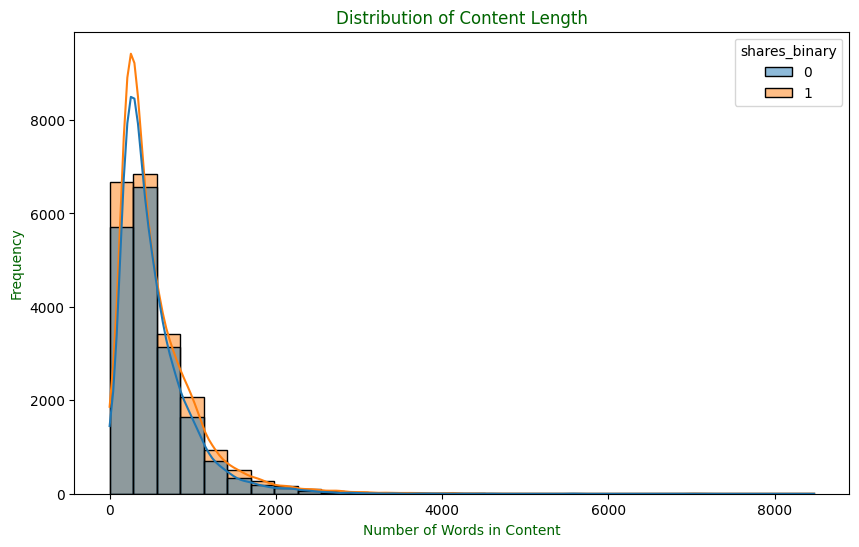

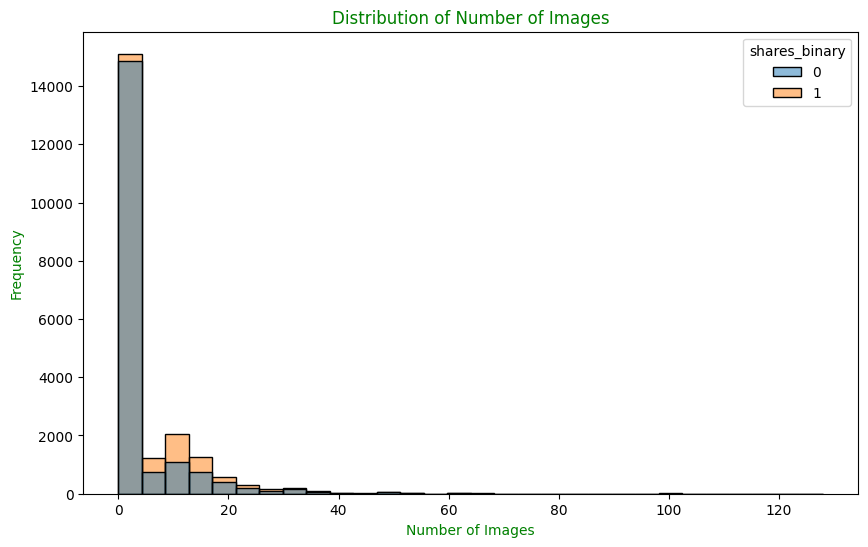

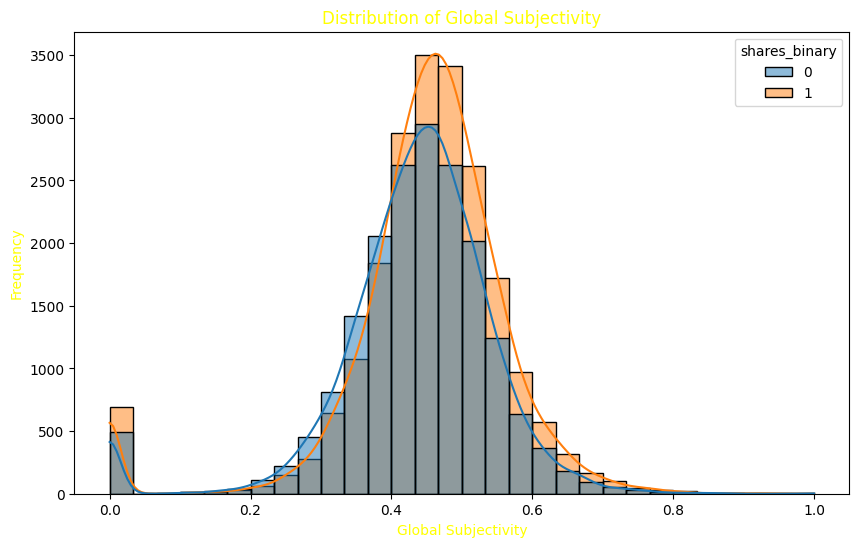

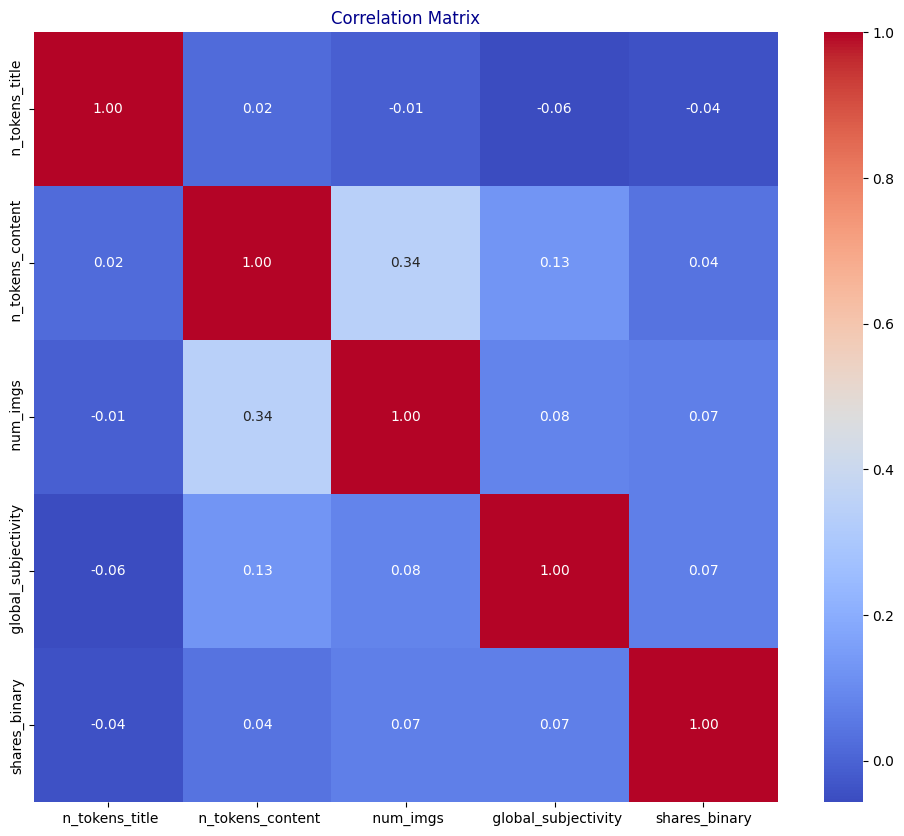

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_spark.toPandas()

# Define features if not defined before
features = [" n_tokens_title", " n_tokens_content", " num_imgs", " global_subjectivity"]

# Plotting the distribution of the number of words in the title
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" n_tokens_title", hue="shares_binary", bins=30, kde=True, color='skyblue')
plt.title("Distribution of Title Length", color='blue')
plt.xlabel("Number of Words in Title", color='blue')
plt.ylabel("Frequency", color='blue')
plt.show()

# Plotting the distribution of the number of words in the content
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" n_tokens_content", hue="shares_binary", bins=30, kde=True, color='darkgreen')
plt.title("Distribution of Content Length", color='darkgreen')
plt.xlabel("Number of Words in Content", color='darkgreen')
plt.ylabel("Frequency", color='darkgreen')
plt.show()

# Plotting the distribution of the number of images
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" num_imgs", hue="shares_binary", bins=30, kde=False, color='darkblue')
plt.title("Distribution of Number of Images", color='green')
plt.xlabel("Number of Images", color='green')
plt.ylabel("Frequency", color='green')
plt.show()

# Plotting the distribution of global subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" global_subjectivity", hue="shares_binary", bins=30, kde=True, color='green')
plt.title("Distribution of Global Subjectivity", color='yellow')
plt.xlabel("Global Subjectivity", color='yellow')
plt.ylabel("Frequency", color='yellow')
plt.show()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df_pandas[features + ["shares_binary"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix", color='darkblue')
plt.show()


5. Model Building
● Split the dataset into training and testing sets (80:20 ratio).
● Train a classification model (e.g., Logistic Regression, Decision Tree, or Random Forest) to predict
article popularity.
● Optionally, explore other algorithms and compare their performances.
6. Model Evaluation
● Evaluate the model's performance using metrics such as accuracy, precision, recall, F1 score, and
AUC-ROC.
● Analyze the confusion matrix to understand the model's strengths and weaknesses.
7. Advanced Analysis (Optional)
● Perform feature importance analysis to identify the most influential features for predicting news
popularity.
● Explore advanced techniques like model tuning and ensemble methods to improve prediction
accuracy.

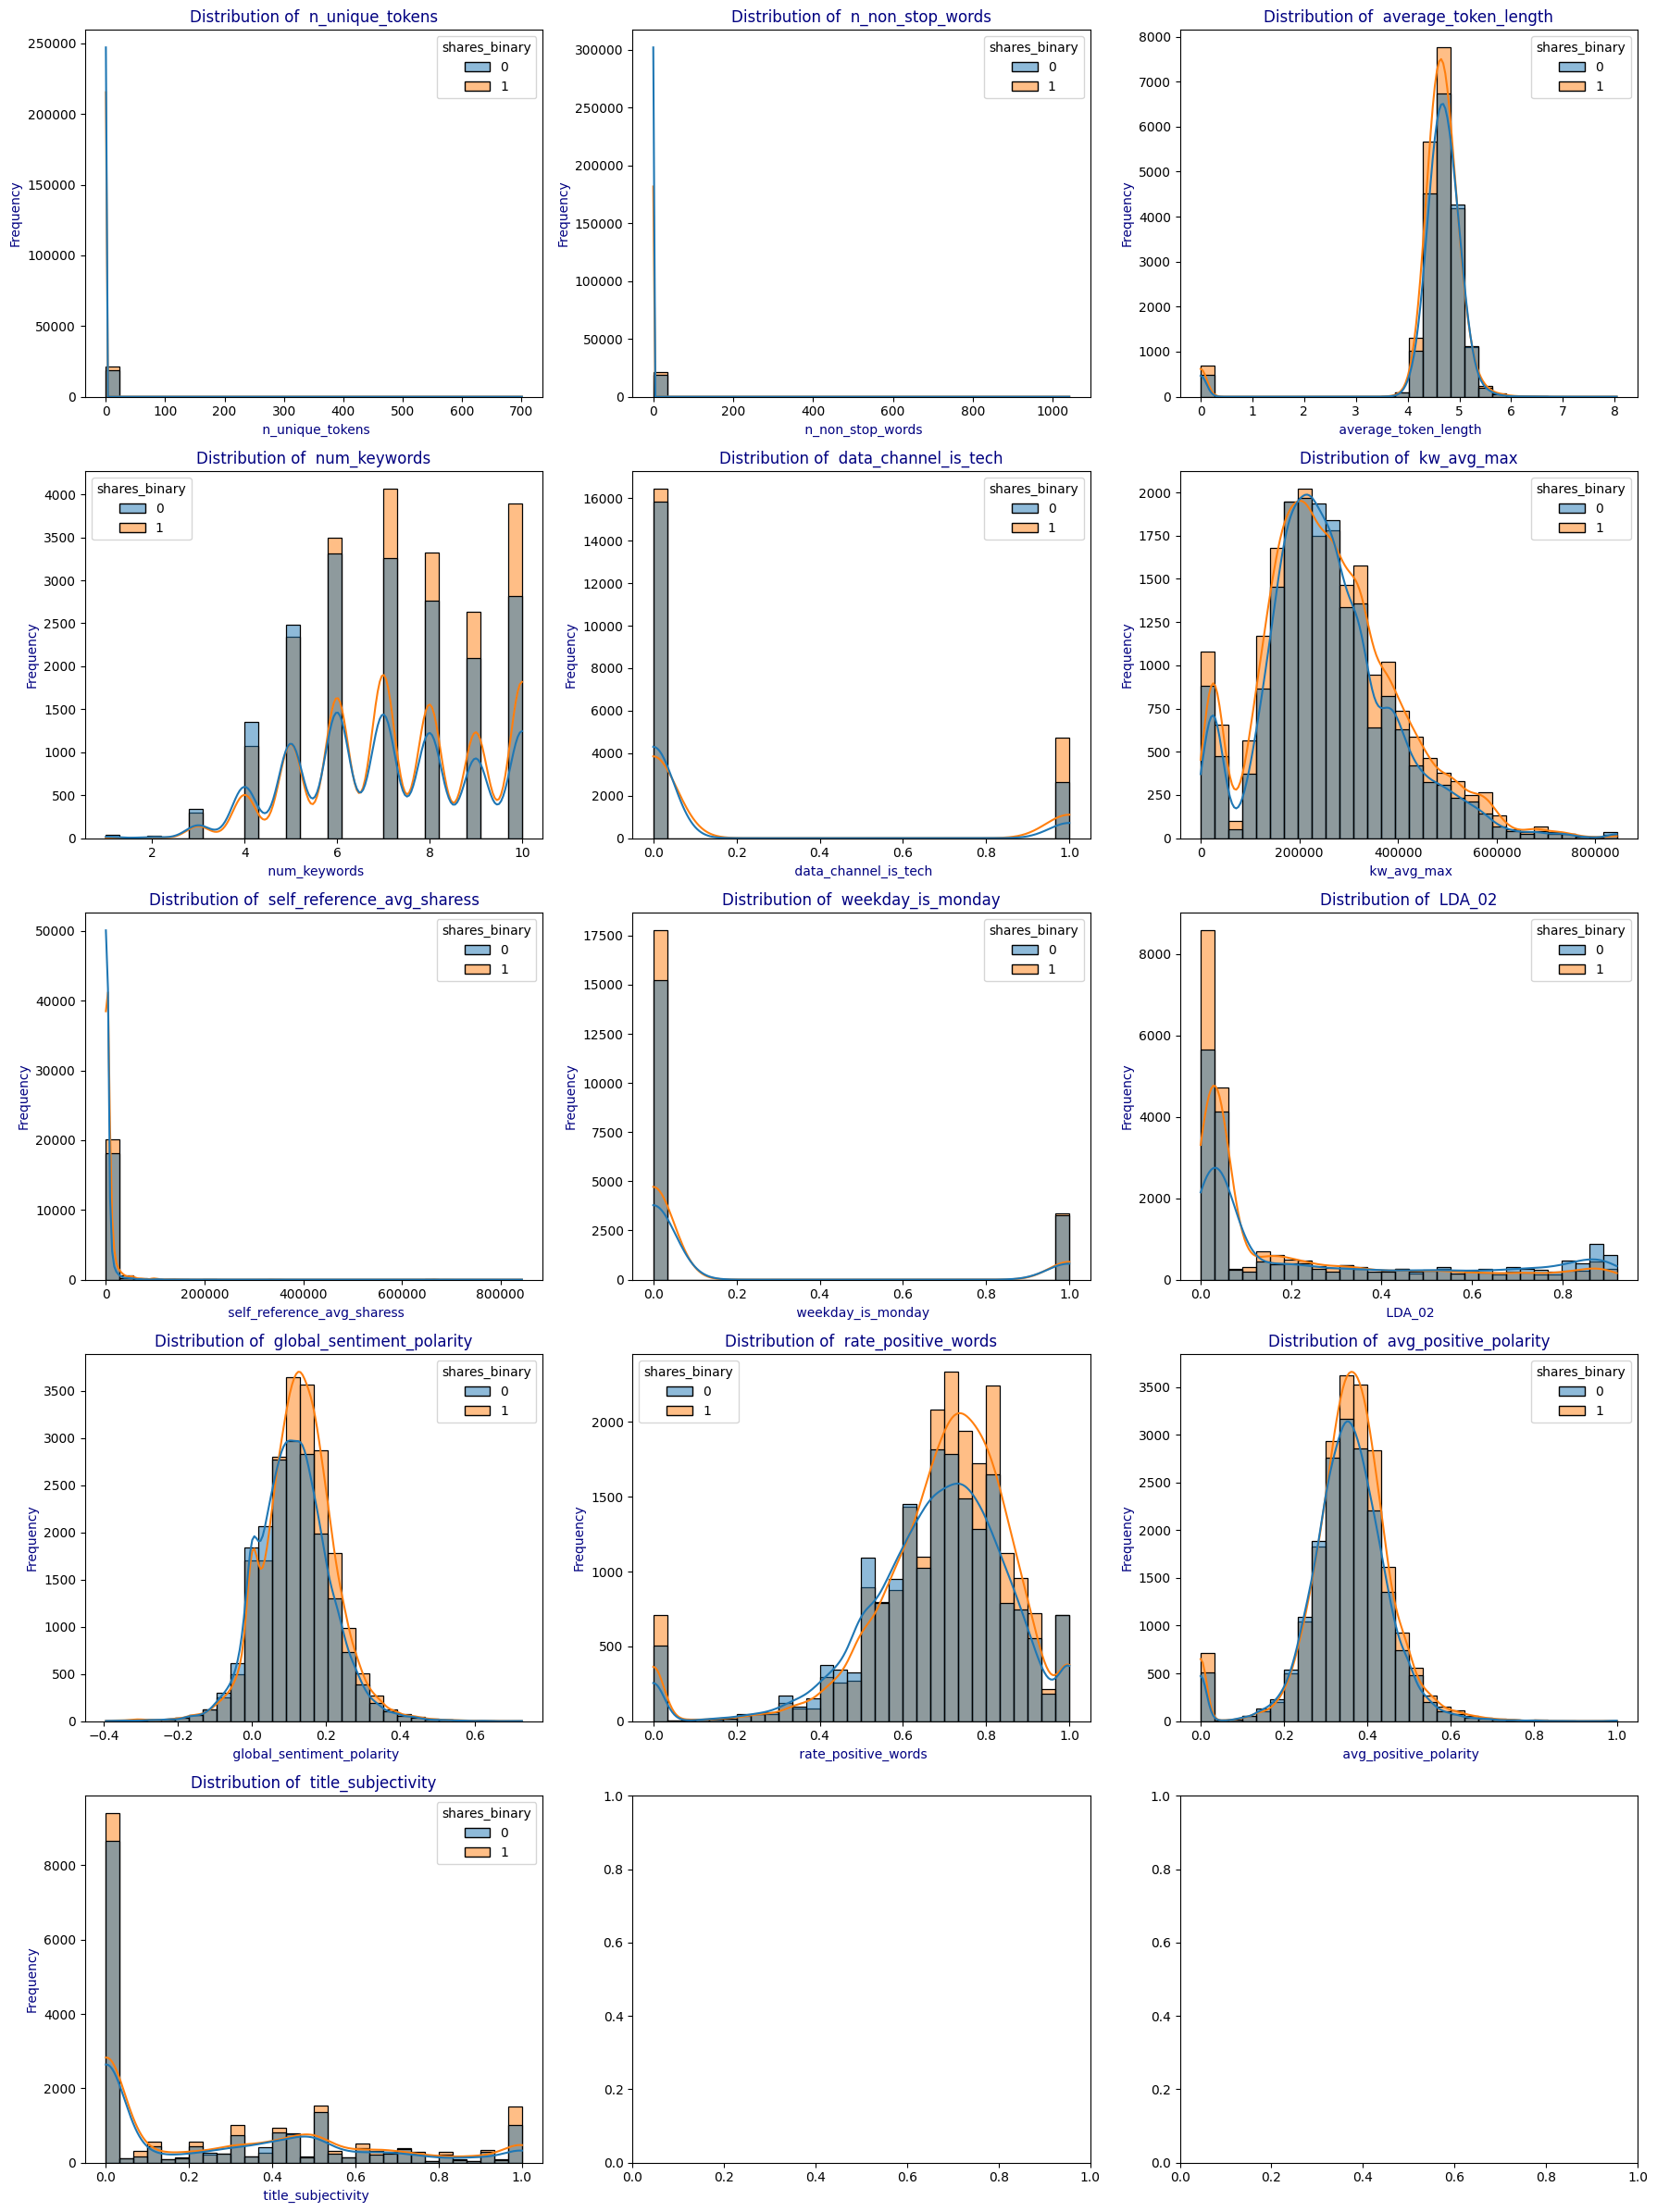

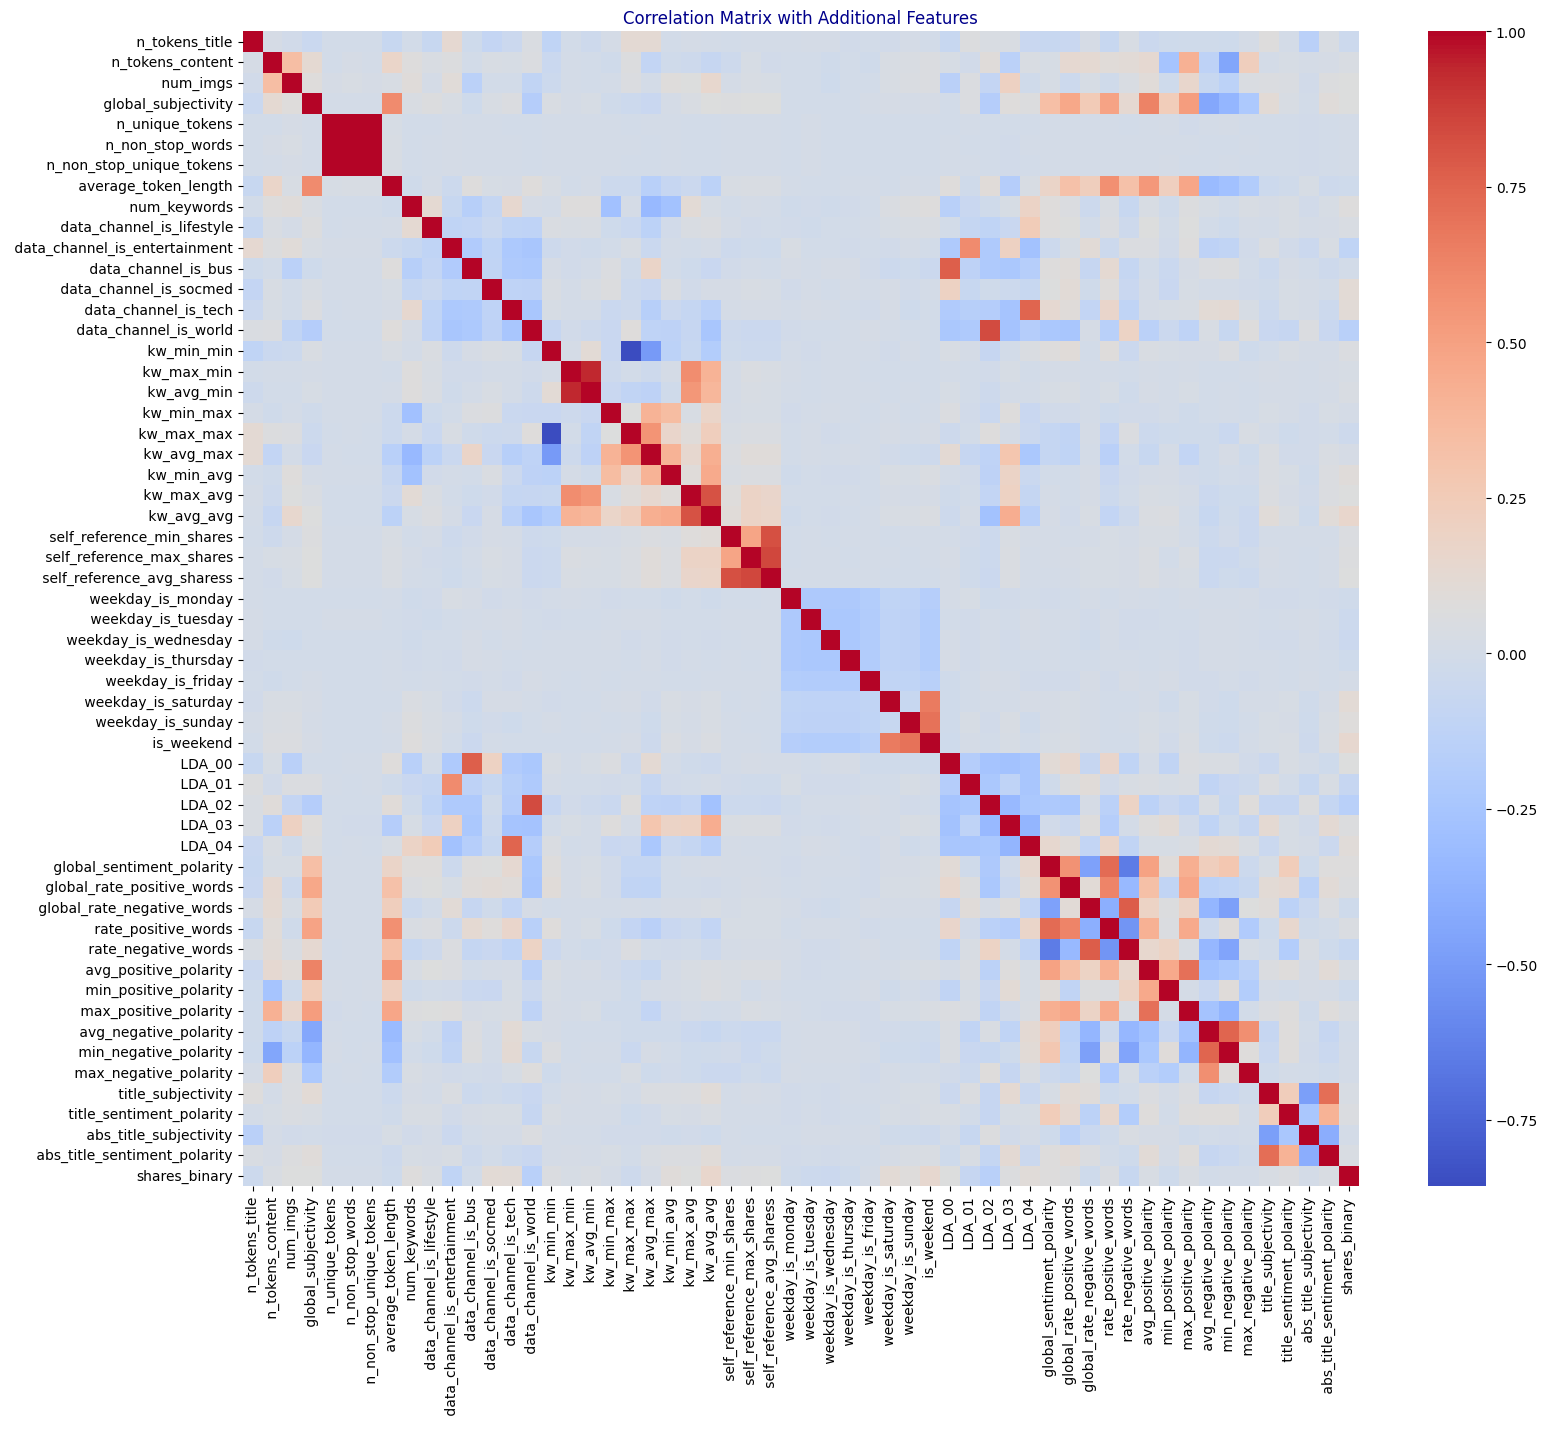

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_spark.toPandas()

# List of additional features for EDA
additional_features = [
    " n_unique_tokens", " n_non_stop_words", " n_non_stop_unique_tokens",
    " average_token_length", " num_keywords", " data_channel_is_lifestyle",
    " data_channel_is_entertainment", " data_channel_is_bus",
    " data_channel_is_socmed", " data_channel_is_tech", " data_channel_is_world",
    " kw_min_min", " kw_max_min", " kw_avg_min", " kw_min_max",
    " kw_max_max", " kw_avg_max", " kw_min_avg", " kw_max_avg", " kw_avg_avg",
    " self_reference_min_shares", " self_reference_max_shares",
    " self_reference_avg_sharess", " weekday_is_monday", " weekday_is_tuesday",
    " weekday_is_wednesday", " weekday_is_thursday", " weekday_is_friday",
    " weekday_is_saturday", " weekday_is_sunday", " is_weekend",
    " LDA_00", " LDA_01", " LDA_02", " LDA_03", " LDA_04",
    " global_sentiment_polarity", " global_rate_positive_words",
    " global_rate_negative_words", " rate_positive_words", " rate_negative_words",
    " avg_positive_polarity", " min_positive_polarity", " max_positive_polarity",
    " avg_negative_polarity", " min_negative_polarity", " max_negative_polarity",
    " title_subjectivity", " title_sentiment_polarity",
    " abs_title_subjectivity", " abs_title_sentiment_polarity"
]

# Plotting histograms for selected features
selected_features = [
    " n_unique_tokens", " n_non_stop_words", " average_token_length",
    " num_keywords", " data_channel_is_tech", " kw_avg_max",
    " self_reference_avg_sharess", " weekday_is_monday", " LDA_02",
    " global_sentiment_polarity", " rate_positive_words", " avg_positive_polarity",
    " title_subjectivity"
]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 24))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.histplot(data=df_pandas, x=feature, hue="shares_binary", bins=30, kde=True, ax=axes[i], color='yellow')
    axes[i].set_title(f"Distribution of {feature}", color='navy')
    axes[i].set_xlabel(feature, color='navy')
    axes[i].set_ylabel("Frequency", color='navy')

plt.tight_layout()
plt.show()

# Correlation analysis with additional features
corr_features = features + additional_features + ["shares_binary"]
corr_matrix = df_pandas[corr_features].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", annot=False)
plt.title("Correlation Matrix with Additional Features", color='darkblue')
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

# Assuming spark is your SparkSession
# df_spark is your PySpark DataFrame

# Calculate the average of n_tokens_title for popular and non-popular articles
avg_n_tokens_title_popular = df_spark.filter(col("shares_binary") == 1).agg(avg(" n_tokens_title")).collect()[0][0]
avg_n_tokens_title_non_popular = df_spark.filter(col("shares_binary") == 0).agg(avg(" n_tokens_title")).collect()[0][0]

print("Average n_tokens_title for Popular Articles:", avg_n_tokens_title_popular)
print("Average n_tokens_title for Non-Popular Articles:", avg_n_tokens_title_non_popular)

Average n_tokens_title for Popular Articles: 10.311761369008225
Average n_tokens_title for Non-Popular Articles: 10.498269334775554


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Assuming spark is your SparkSession
# df_spark is your PySpark DataFrame

# Create a new feature for article length categories
df_spark = df_spark.withColumn(" article_length_category",
                               when(col(" n_tokens_content") < 500, "Short")
                               .when((col(" n_tokens_content") >= 500) & (col(" n_tokens_content") < 1000), "Medium")
                               .otherwise("Long"))

# Create a new feature for the weekday of publication
weekday_columns = [" weekday_is_monday", " weekday_is_tuesday", " weekday_is_wednesday",
                    " weekday_is_thursday", " weekday_is_friday", " weekday_is_saturday", " weekday_is_sunday"]

df_spark = df_spark.withColumn("publication_weekday",
                               when(col(" weekday_is_monday") == 1, "Monday")
                               .when(col(" weekday_is_tuesday") == 1, "Tuesday")
                               .when(col(" weekday_is_wednesday") == 1, "Wednesday")
                               .when(col(" weekday_is_thursday") == 1, "Thursday")
                               .when(col(" weekday_is_friday") == 1, "Friday")
                               .when(col(" weekday_is_saturday") == 1, "Saturday")
                               .when(col(" weekday_is_sunday") == 1, "Sunday")
                               .otherwise("Unknown"))

# Show the first few rows of the DataFrame with new features
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler

# Define UDFs for new features
def article_length_category(length):
    if length < 500:
        return 'short'
    elif 500 <= length < 1500:
        return 'medium'
    else:
        return 'long'

def weekday_of_publication(monday, tuesday, wednesday, thursday, friday, saturday, sunday):
    days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]
    return ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][days.index(1)]

article_length_category_udf = udf(article_length_category, StringType())
weekday_of_publication_udf = udf(weekday_of_publication, StringType())

# Create new features
df_spark = df_spark.withColumn('article_length_category', article_length_category_udf(df_spark[' n_tokens_content']))
df_spark = df_spark.withColumn('weekday_of_publication', weekday_of_publication_udf(df_spark[' weekday_is_monday'], df_spark[' weekday_is_tuesday'], df_spark[' weekday_is_wednesday'], df_spark[' weekday_is_thursday'], df_spark[' weekday_is_friday'], df_spark[' weekday_is_saturday'], df_spark[' weekday_is_sunday']))

# Use VectorAssembler to combine all feature columns into a single vector column
feature_columns = [col for col in df_spark.columns if col not in ['shares', 'label', 'article_length_category', 'weekday_of_publication']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the DataFrame
df_spark = assembler.transform(df_spark)

IllegalArgumentException: Data type string of column  article_length_category is not supported.
Data type string of column publication_weekday is not supported.